In [1]:
import pandas as pd 
import numpy as np 
import pickle as pkl
from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import KFold,StratifiedKFold

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve, fbeta_score, f1_score 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

import imblearn.over_sampling


from sklearn.metrics import log_loss
from sklearn import metrics

import warnings
warnings.simplefilter(action='ignore')


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('cleaned_dataset.csv')
df.head()

,heart_attack_disease,sex,age,race_ethn,bmi,overweight,diabetes,diagnose_strk,smoker,high_bp,high_chol,heavy_drinker,exercise,fruit,vege
0,0.0,1.0,70.0,0.0,15.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1,1.0,1.0,67.0,1.0,28.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,72.0,1.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,62.0,0.0,33.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
4,1.0,0.0,76.0,5.0,29.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
df.heart_attack_disease.value_counts()

0.0    347607
1.0     33540
Name: heart_attack_disease, dtype: int64

In [4]:
df.heart_attack_disease.value_counts(normalize = True)

0.0    0.912002
1.0    0.087998
Name: heart_attack_disease, dtype: float64

In [5]:
#class is imbalanced , will use techniques to handle imbalance in order to improve metric scores

In [6]:
X = df.drop(['heart_attack_disease'], axis = 1)
y = df['heart_attack_disease']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state=42, 
                                                   stratify = y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [8]:
X_train.shape

(266802, 14)

In [9]:
X_test.shape

(114345, 14)

In [10]:
y_train.value_counts()

0.0    243324
1.0     23478
Name: heart_attack_disease, dtype: int64

XGBoost


Retrain w/ Best Hyperparameters

In [11]:
xg_weight = XGBClassifier(objective = 'binary:logistic', use_label_encoder = False, 
                            base_score = 0.5, booster = 'gbtree', callbacks = None,
                            colsample_bylevel = 1, colsample_bynode = 1, colsample_bytree = 1,
                            early_stopping_rounds = None, enable_categorical = False, 
                            eval_metric = None, gamma = 0, gpu_id = -1, grow_policy = 'depthwise',
                            importance_type = None, interaction_constraints = '',
                            learning_rate = 0.300000012, max_bin = 256, max_cat_to_onehot = 4, 
                            max_delta_step = 0, max_depth = 3, max_leaves = 0, min_child_weight = 1,
                            monotone_constraints = '()', n_estimators =  100, n_jobs = 0,
                            num_parallel_tree = 1, predictor = 'auto', random_state = 0, reg_alpha = 0,
                            reg_lambda = 1, sampling_method = 'uniform', scale_pos_weight = 10.36391515461283,
                            subsample = 1, tree_method = 'exact', validate_parameters = 1, verbosity = None)

xg_weight.fit(X_train, y_train)
xg_pred_weight = xg_weight.predict(X_test)

xg_acc_weight = xg_weight.score(X_test, y_test)
xg_precision_weight= precision_score(y_test, xg_pred_weight)
xg_recall_weight = recall_score(y_test, xg_pred_weight)
xg_f1_weight = f1_score(y_test, xg_pred_weight)

model_probs = xg_weight.predict_proba(X_test)[:,1]
xg_fpr_weight, xg_tpr_weight, xg_thresholds_weight = roc_curve(y_test, model_probs)
roc_auc_xg_weight = auc(xg_fpr_weight,xg_tpr_weight)

print(f'XGBoost (Test) Class Weight: Accuracy: {xg_acc_weight:.6f}')
print(f'XGBoost (Test) Class Weight: Precision: {xg_precision_weight:.6f}')
print(f'XGBoost (Test) Class Weight: Recall : {xg_recall_weight:.6f}')
print(f'XGBoost (Test) Class Weight: F1 : {xg_f1_weight:.6f}')
print(f'XGBoost (Test) Class Weight: Roc : {roc_auc_xg_weight:.6f}')


XGBoost (Test) Class Weight: Accuracy: 0.708269
XGBoost (Test) Class Weight: Precision: 0.204545
XGBoost (Test) Class Weight: Recall : 0.801431
XGBoost (Test) Class Weight: F1 : 0.325910
XGBoost (Test) Class Weight: Roc : 0.822102


Find the threshold for best recall score 

XGBoost Model best Recall score 0.983 at prob decision threshold >= 0.100


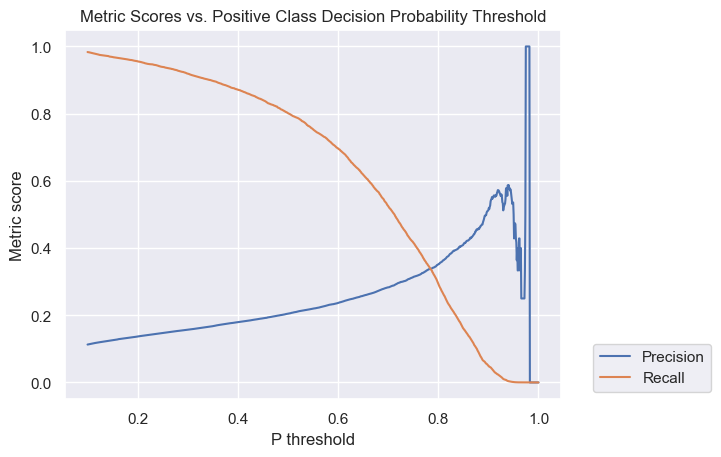

In [12]:
sns.set()
X_val, y_val = X_test, y_test

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = xg_weight.predict_proba(X_val)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    
#plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
#plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['Precision','Recall'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_recall_score = np.max(rec_scores) 
best_thresh_p = thresh_ps[np.argmax(rec_scores)]

print(f'XGBoost Model best Recall score {best_recall_score:.3f} at prob decision threshold >= {best_thresh_p:.3f}')

plt.savefig('final_model_thresh.png', bbox_inches='tight')


In [13]:
def make_confusion_matrix(model, threshold):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_s)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no disease', 'disease'],
           yticklabels=['no disease', 'disease']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [14]:
#w/o threshold tuning 

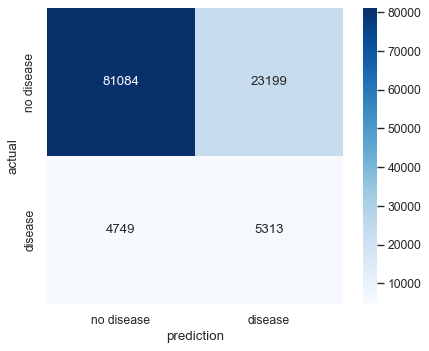

In [15]:
make_confusion_matrix(xg_weight, 0.5)

In [16]:
#w/ best threshold for best recall score 

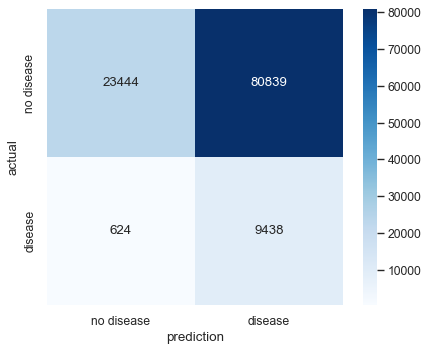

In [17]:
make_confusion_matrix(xg_weight,0.1)

In [18]:
#business case --> want to get optimal recall, if we follow through selecting best precision score -- risk of getting low recall scores in stead 

In [19]:
#using threshold value , calc scores for other metrics 
X_val_2, y_val_2 = X_test, y_test
xg_weight_2 = XGBClassifier(objective = 'binary:logistic', use_label_encoder = False, 
                            base_score = 0.5, booster = 'gbtree', callbacks = None,
                            colsample_bylevel = 1, colsample_bynode = 1, colsample_bytree = 1,
                            early_stopping_rounds = None, enable_categorical = False, 
                            eval_metric = None, gamma = 0, gpu_id = -1, grow_policy = 'depthwise',
                            importance_type = None, interaction_constraints = '',
                            learning_rate = 0.300000012, max_bin = 256, max_cat_to_onehot = 4, 
                            max_delta_step = 0, max_depth = 3, max_leaves = 0, min_child_weight = 1,
                            monotone_constraints = '()', n_estimators =  100, n_jobs = 0,
                            num_parallel_tree = 1, predictor = 'auto', random_state = 0, reg_alpha = 0,
                            reg_lambda = 1, sampling_method = 'uniform', scale_pos_weight = 10.36391515461283,
                            subsample = 1, tree_method = 'exact', validate_parameters = 1, verbosity = None)

xg_weight_2.fit(X_train, y_train)

model_val = xg_weight.predict_proba(X_val_2)[:,1] >= 0.1


xg_acc_weight_2 = accuracy_score(y_val_2, model_val)
xg_precision_weight_2= precision_score(y_val_2, model_val)
xg_recall_weight_2 = recall_score(y_val_2, model_val)
xg_f1_weight_2 = f1_score(y_val_2, model_val)

xg_fpr_weight_2, xg_tpr_weight_2, xg_thresholds_weight_2 = roc_curve(y_val_2, model_val)
roc_auc_xg_weight_2 = auc(xg_fpr_weight_2,xg_tpr_weight_2)

print(f'XGBoost (Test) Class Weight + Adjusted Threshold: Accuracy: {xg_acc_weight_2:.6f}')
print(f'XGBoost (Test) Class Weight + Adjusted Threshold: Precision: {xg_precision_weight_2:.6f}')
print(f'XGBoost (Test) Class Weight + Adjusted Threshold: Recall : {xg_recall_weight_2:.6f}')
print(f'XGBoost (Test) Class Weight + Adjusted Threshold: F1 : {xg_f1_weight_2:.6f}')
print(f'XGBoost (Test) Class Weight + Adjusted Threshold: Roc : {roc_auc_xg_weight_2:.6f}')


XGBoost (Test) Class Weight + Adjusted Threshold: Accuracy: 0.317819
XGBoost (Test) Class Weight + Adjusted Threshold: Precision: 0.112787
XGBoost (Test) Class Weight + Adjusted Threshold: Recall : 0.983403
XGBoost (Test) Class Weight + Adjusted Threshold: F1 : 0.202364
XGBoost (Test) Class Weight + Adjusted Threshold: Roc : 0.618501


Feature Importance 

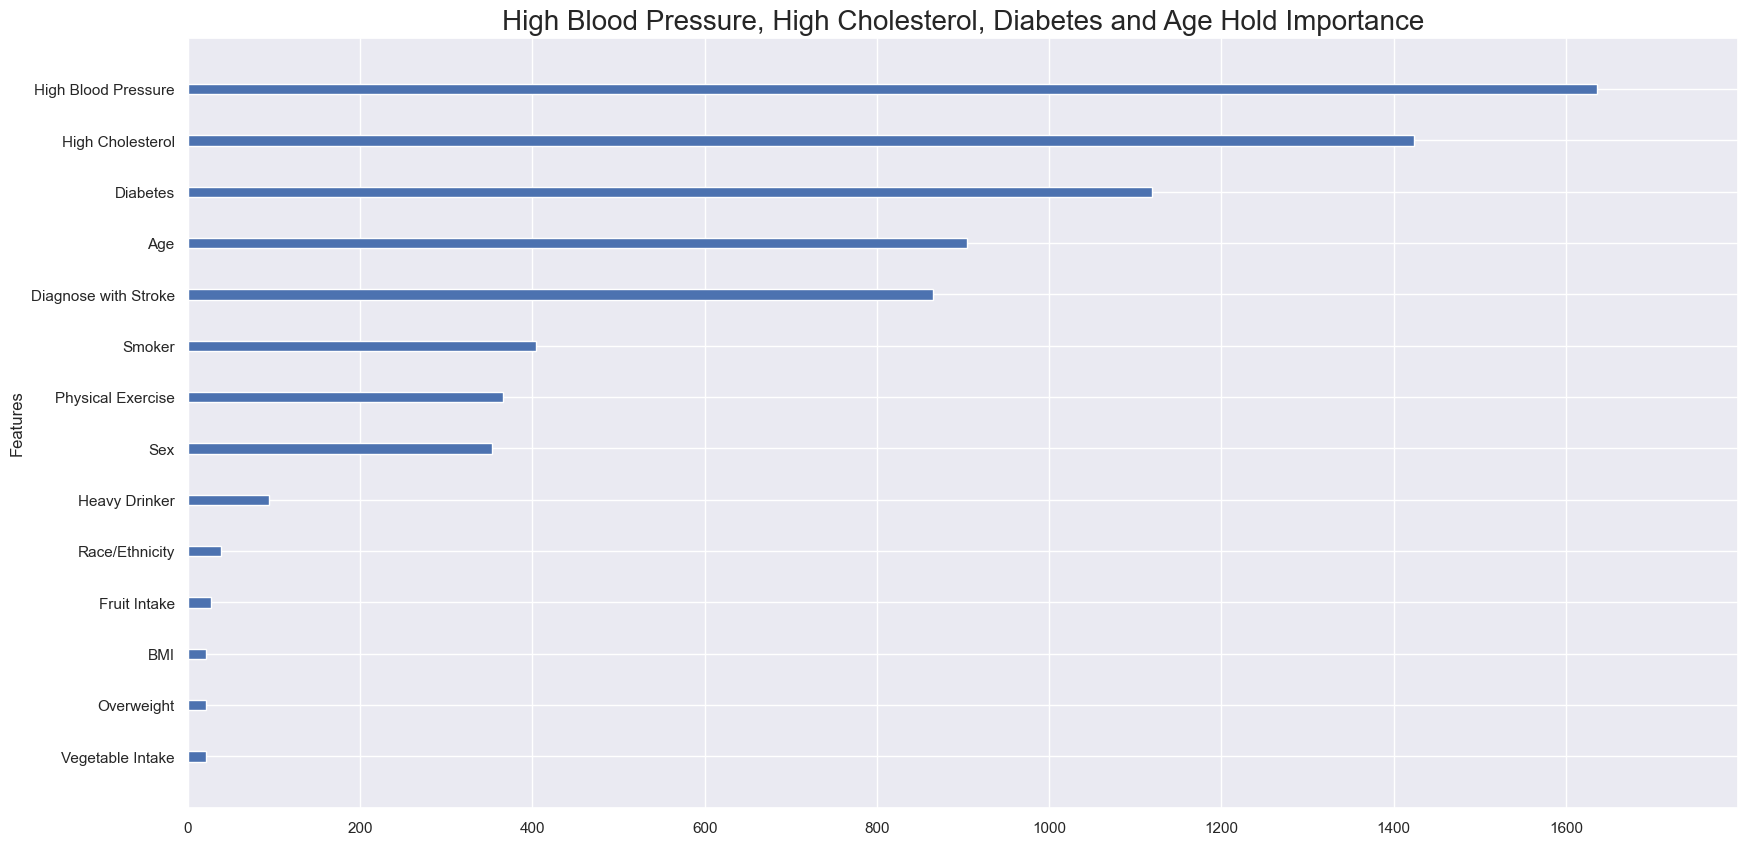

In [28]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
xgb.plot_importance(xg_weight, importance_type='gain', ax=ax, show_values=False)

plt.title('High Blood Pressure, High Cholesterol, Diabetes and Age Hold Importance', fontsize = 20)
plt.xlabel('')



labels = ['Vegetable Intake','Overweight','BMI','Fruit Intake', 
        'Race/Ethnicity', 'Heavy Drinker', 'Sex', 
        'Physical Exercise', 'Smoker', 'Diagnose with Stroke', 'Age', 
        'Diabetes', 'High Cholesterol', 'High Blood Pressure']

ax.set_yticklabels(labels, minor=False)
plt.savefig('final_model_ft_gain.png', bbox_inches='tight')

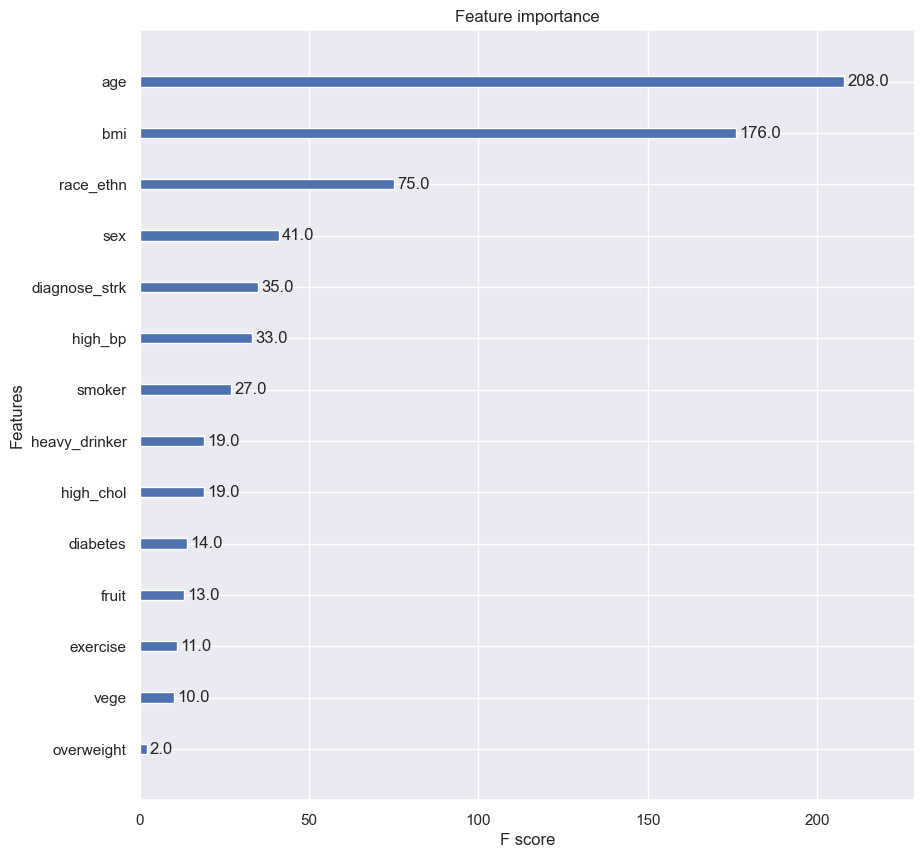

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
xgb.plot_importance(xg_weight,ax=ax)
plt.savefig('final_model_ft.png', bbox_inches='tight')

In [30]:
xg_weight.get_booster().get_score(importance_type='weight') #extract raw frequency scores

{'sex': 41.0,
 'age': 208.0,
 'race_ethn': 75.0,
 'bmi': 176.0,
 'overweight': 2.0,
 'diabetes': 14.0,
 'diagnose_strk': 35.0,
 'smoker': 27.0,
 'high_bp': 33.0,
 'high_chol': 19.0,
 'heavy_drinker': 19.0,
 'exercise': 11.0,
 'fruit': 13.0,
 'vege': 10.0}

In [35]:
xg_weight.get_booster().get_score(importance_type='gain') #extract raw gain scores

{'sex': 352.8609313964844,
 'age': 904.9654541015625,
 'race_ethn': 38.13020324707031,
 'bmi': 21.2675724029541,
 'overweight': 20.96286392211914,
 'diabetes': 1118.901611328125,
 'diagnose_strk': 865.2650756835938,
 'smoker': 404.4980773925781,
 'high_bp': 1635.91748046875,
 'high_chol': 1423.6861572265625,
 'heavy_drinker': 93.7409896850586,
 'exercise': 366.1516418457031,
 'fruit': 26.956233978271484,
 'vege': 20.809091567993164}

Predict using model 

In [ ]:
df.head()

In [ ]:
test_array = (df.iloc[4, 1:].to_list())
test_array
print((test_array))

In [ ]:
test_array = np.array(test_array).reshape((1,-1))


In [ ]:
predict_test = xg_weight.predict(test_array)
predict_test

In [ ]:
with open("/Users/hannahkim/project/project4/xgboost_model.pkl", "wb") as f:
    pkl.dump(xg_weight, f)